## **AN EMOTION BASED MUSIC RECOMMENDER SYSTEM USING DEEP LEARNING**

# **1. Import Libraries**



---



In [40]:
import random
import numpy as np
import pandas as pd
!pip install -q --upgrade librosa
import librosa
import librosa.display
import soundfile as sf
import os
import matplotlib as mpl
from distutils.dir_util import copy_tree
from shutil import copy2
import matplotlib.pyplot as plt
import math
import random
import IPython as ip
!pip install -q split-folders
import splitfolders
import tensorflow as tf
from tensorflow import keras
import shutil
from shutil import copy
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **2. SET THE ROOT PATH**

In [41]:
base_path='GDrive/My Drive/MSc Project/RAVDESS'
audio_path = base_path+'/audio/'

# 3. UTILITY FUNCTION DEFINITIONS

A google account is required for this implementation of the project as GoogleFileStream is required to work in Colab. The google_connection() function is used to create a link to a google drive account.

In [42]:
def google_connection():
  google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
  if (google[0] is '0'):
    from google.colab import drive
    drive.mount('/content/drive')
    drive.mount('/content/GDrive/')
  !if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi

The preprocess utility function performs all the required operations to transform the raw audio files into spectrograms.
The following operations are carried out in the function - 


1.   Creation of subfolders in the root folder for the project with the create_folders() function
2.   Extraction of 128 MFCC from the clean audio file using the extract_features() function
3.   Generation of White Noise to simulate Environment and Equipment Noise using the get_white_noise() function.
4.   Generation of External Noise to simulate a noisy environment using the get_urban_noise() function.
5.   A lookup table is created to store the metadata of the audio files using the create_lookup_table() function.
6.   Conversion of the audio files into their repective spectrograms is performed using the create_mel_spec() function.
7.   The files are sorted and organized to the format required by the CNN generator with the copy_to_spec_folder() function
8.   The splitting of the files into training, testing and validation folders is done using the other_operations() function.






**CREATE FOLDERS**

In [43]:
def create_folders(base_path=base_path, clean_audio_dir=audio_path): 
  emotions = ['Angry', 'Sad', 'Calm', 'Happy', 'Disgust', 'Fearful', 'Surprised', 'Neutral']
  t = ['train', 'validation', 'test']
  u = ['mel_spectrogram', 'mel_spectrogram_white_noisy', 'mel_spectrogram_urban_noisy', 'mel_spectrogram_white_urban_noisy', 'combined_directory']
  v = ['mel_spectrogram_temp', 'mel_spectrogram_temp_white_noisy', 'mel_spectrogram_temp_urban_noisy', 'mel_spectrogram_temp_white_urban_noisy']
  w=['white_noisy_audio', 'urban_noisy_audio', 'white_urban_noisy_audio']

  directory=clean_audio_dir

  for m in w:
    if os.path.isdir(os.path.join(base_path,m)) == False:   
      os.mkdir(os.path.join(base_path,m))
      os.mkdir(base_path+'/{}/folder'.format(m))

  for m in v:
    for emotion in emotions:
      if os.path.isdir(base_path+'/{}'.format(m)) == False:
        os.mkdir(base_path+'/{}'.format(m))
      if os.path.isdir(base_path+'/{}/{}'.format(m, emotion)) == False:   
        os.mkdir(base_path+'/{}/{}'.format(m, emotion))      
  for m in u:
    for a in t:
      for emotion in emotions:
        if os.path.isdir(base_path+'/{}'.format(m)) == False:
            os.mkdir(base_path+'/{}'.format(m))
        if os.path.isdir(base_path+'/{}/{}'.format(m,a)) == False:    
            os.mkdir(base_path+'/{}/{}'.format(m,a))
        if os.path.isdir(base_path+'/{}/{}/{}'.format(m,a,emotion)) == False:   
            os.mkdir(base_path+'/{}/{}/{}'.format(m,a,emotion))

  os.mkdir('GDrive/My Drive/MSc Project/Predictions')
  os.mkdir('GDrive/My Drive/MSc Project/Predictions/test')
  os.mkdir('GDrive/My Drive/MSc Project/Predictions/test/prediction_folder')
  os.mkdir('GDrive/My Drive/MSc Project/Predictions/audio')

  shutil.copy(base_path+'/audio/Actor_01/{}'.format(random.choice(os.listdir(base_path+'/audio/Actor_01'))), 'GDrive/My Drive/MSc Project/Predictions/audio')

**EXTRACT MFCC COEFFICIENTS FOR ALL AUDIO FILES**

---


Here we extract 128 mel coefficients from each audio file

In [44]:
def extract_features(file_name):
  try:
    audio, sr = librosa.load(file_name) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=128)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    
  except:
    mfccs_processed = 'Error'
  return mfccs_processed 

**GENERATE WHITE NOISE**

---
Here white noise is generated to mimic environmental noise such as wind


In [45]:
def get_white_noise(signal,SNR):
  RMS_s=math.sqrt(np.mean(signal**2))
  RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
  STD_n=RMS_n
  noise=np.random.normal(0, STD_n, signal.shape[0])
  
  return noise

**GENERATE URBAN NOISE**

---
Urban Noise is taken from the urbansound8k dataset to be merged with the original audio


In [46]:
def get_urban_noise(signal,noise,SNR):
  RMS_s=math.sqrt(np.mean(signal**2))
  RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
  RMS_n_current=math.sqrt(np.mean(noise**2))
  noise=noise*(RMS_n/RMS_n_current)
    
  return noise

**CREATE THE LOOKUP TABLE FOR AUDIO FILES AND THEIR METADATA**

In [47]:
def create_lookup_table(audio_path,y=0):
  directory=audio_path
  data=pd.DataFrame(columns=['filename', 'modality', 'vocal_channel', 'emotion', 'emotion_intensity', 'statement', 'repetition', 'actor', 'actor_sex', 'audio_format'])
  for folder in os.listdir(directory):
    nextfile = directory + '/' + folder
    for entry in os.listdir(nextfile):
      if os.path.isfile(os.path.join(nextfile, entry)):
        head, tail = entry.split('.')
        value = head.split('-')
        try:
          if int(value[-1])%2 == 0:
            value.append('female')
          else: 
            value.append('male')
        except:
          if int(value[-1][0:-1])%2 == 0:
            value.append('female')
          else: 
            value.append('male')

        value.append(tail)
        value.insert(0, entry)
        
        y+=1
      data.at[y]=value
      y+=1
    else:
      pass
  modality_dic = {'01':'full-AV', '02':'video-only', '03':'audio-only'}
  vocal_channel_dic = {'01':'speech', '02':'song'}
  emotion_dic = {'01':'Neutral', '02':'Calm', '03':'Happy', '04':'Sad', '05':'Angry', '06':'Fearful', '07':'Disgust', '08':'Surprised'}
  emotion_intensity_dic = {'01':'Normal', '02':'Strong'}
  statement_dic = {'01':'Kids are talking by the door', '02':'Dogs are sitting by the door'}
  repetition_dic = {'01':'1st repetition', '02':'2nd repetition'}
  changes = ['modality', 'vocal_channel', 'emotion', 'emotion_intensity', 'statement', 'repetition']
  changes2 = [modality_dic, vocal_channel_dic, emotion_dic, emotion_intensity_dic, statement_dic, repetition_dic]

  for change in changes:
    data[change] = data[change].replace(changes2[changes.index(change)].keys(), changes2[changes.index(change)].values())
    
  data['actor']='Actor '+data['actor']
  return data

**GENERATE MEL SPECTROGRAMS**

In [48]:
def create_mel_spec(a, data, output_folder, noisy=False, noise_type=''):
  directory=a
  for folder in os.listdir(directory):
    nextfile = directory + '/' + folder
    for entry in os.listdir(nextfile):
      if noisy==True:
        audio, sr = librosa.load(nextfile+ '/' + entry)
        #AUDIO TRIMMING TO REMOVE SILENCE
        audio, index = librosa.effects.trim(audio, top_db=45)  #HERE WE USE A MAXIMUM DB LIMIT OF 45 TO DEFINE A SILENCE THRESHOLD AS DISCUSSED IN THE REPORT.
        if noise_type=='white':
          import soundfile as sf
          noise=get_white_noise(audio, SNR=random.randint(10,20)) #HERE WE USE A RANDOM SNR BETWEEN 10 AND 20 AS DISCUSSED IN THE REPORT.
          audio_noise = audio+noise
          sf.write(base_path+'/white_noisy_audio/folder/{}w.wav'.format(entry[0:-4]), data = audio_noise, samplerate = sr)
        elif noise_type=='urban':
          import soundfile as sf
          a = random.choice(os.listdir(base_path+'/UrbanSound8K/audio/fold1/'))
          try:
            sound, sr2 = librosa.load(base_path+'/UrbanSound8K/audio/fold1/{}'.format(a))
          except:
            continue
          noise=get_urban_noise(audio, sound ,SNR=random.randint(10,20)) #HERE WE USE A RANDOM SNR BETWEEN 10 AND 20 AS DISCUSSED IN THE REPORT.

          mark = True
          while mark==True:
            if len(noise)>len(audio):
              audio = np.append(audio,0)
            elif len(noise)<len(audio):
              noise = np.append(noise, 0)
            elif len(noise)==len(audio):
              mark = False
          audio_noise = audio+noise
          #data[data['filename']==entry[0:19]]['Duration(u)'] = librosa.get_duration(audio_noise)
          
          sf.write(base_path+'/urban_noisy_audio/folder/{}u.wav'.format(entry[0:-4]), data = audio_noise, samplerate = sr)
        elif noise_type=='both':
          noise=get_white_noise(audio, SNR=random.randint(10,20)) #HERE WE USE A RANDOM SNR BETWEEN 10 AND 20 AS DISCUSSED IN THE REPORT.
          audio_noise = audio+noise
          import soundfile as sf
          a = random.choice(os.listdir(base_path+'/UrbanSound8K/audio/fold1/'))
          try:
            sound, sr2 = librosa.load(base_path+'/UrbanSound8K/audio/fold1/{}'.format(a))
          except:
            continue
          noise=get_urban_noise(audio, sound ,SNR=random.randint(10,20))

          mark = True
          while mark==True:
            if len(noise)>len(audio_noise):
              audio_noise = np.append(audio_noise,0)
            elif len(noise)<len(audio_noise):
              noise = np.append(noise, 0)
            elif len(noise)==len(audio_noise):
              mark = False
          audio_noise = audio_noise+noise
          #data[data['filename']==entry[0:19]]['Duration(wu)'] = librosa.get_duration(audio_noise)
          sf.write(base_path+'/white_urban_noisy_audio/folder/{}v.wav'.format(entry[0:-4]), data = audio_noise, samplerate = sr)
        folder_emotion = data[data['filename']==entry]['emotion'].iloc[0]

        #DEPENDING ON THE VOCAL CHANNEL USED FOR THE AUDIO RECORDING, WE HAVE TWO POSSIBLE OPTIONS FOR N_FFT OPTION, (512 FOR REGULAR SPEECH AND 2048 FOR SONG)
        if data[data['filename']==entry]['vocal_channel'].iloc[0]=='speech':
          S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128,fmax=8000, n_fft = 512)
        elif data[data['filename']==entry]['vocal_channel'].iloc[0]=='song':
          S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128,fmax=8000, n_fft = 2048)
        plt.figure(figsize=(4, 4))
        S_dB = librosa.power_to_db(S, ref=np.max)
        
      else:
        try:
          audio, sr = librosa.load(nextfile+ '/' + entry)
          #AUDIO TRIMMING TO REMOVE SILENCE
          audio, index = librosa.effects.trim(audio, top_db=45)
          data[data['filename']==entry[0:19]]['Duration'] = librosa.get_duration(audio)
          folder_emotion = data[data['filename']==entry]['emotion'].iloc[0]
          if data[data['filename']==entry]['vocal_channel'].iloc[0]=='speech':
            S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, n_fft = 512)
          elif data[data['filename']==entry]['vocal_channel'].iloc[0]=='song':
            S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, n_fft = 2048)
          plt.figure(figsize=(4, 4))
          S_dB = librosa.power_to_db(S, ref=np.max)
          
        except:
          continue

      #SAVE THE SPECTROGRAMS TO DISK
      librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
      try:
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram {}'.format(folder_emotion))
        plt.tight_layout()

      #WE ADDDED LETTERS AFTER THE ORIGINAL NAMES OF THE SPECTROGRAMS TO DIFFERENTIATE THEM. W FOR WHITE NOISE OVERLAY, U FOR URBAN NOISE OVERLAY AND WU FOR BOT KINDS OF NOISE
        if noise_type=='white':
          plt.savefig(base_path+output_folder+'/{}/{}w.png'.format(folder_emotion, entry[0:-4]))
        elif noise_type=='urban':
          plt.savefig(base_path+output_folder+'/{}/{}u.png'.format(folder_emotion, entry[0:-4]))
        elif noise_type=='both':
          plt.savefig(base_path+output_folder+'/{}/{}v.png'.format(folder_emotion, entry[0:-4]))
        else:
          plt.savefig(base_path+output_folder+'/{}/{}.png'.format(folder_emotion, entry[0:-4]))
        plt.clf()
      except:
        continue

**MOVE THE FOLDERS TO THE APPROPRIATE DIRECTORIES**

In [49]:
def copy_to_spec_folder():
  v = ['mel_spectrogram_temp', 'mel_spectrogram_temp_white_noisy', 'mel_spectrogram_temp_urban_noisy', 'mel_spectrogram_temp_white_urban_noisy']
  for w in v:
    if w == 'mel_spectrogram_temp':
      perm_directory=base_path+'/mel_spectrogram'
      
    elif w == 'mel_spectrogram_temp_white_noisy':
      perm_directory=base_path+'/mel_spectrogram_white_noisy'

    elif w == 'mel_spectrogram_temp_urban_noisy':
      perm_directory=base_path+'/mel_spectrogram_urban_noisy'

    elif w == 'mel_spectrogram_temp_white_urban_noisy':
      perm_directory=base_path+'/mel_spectrogram_white_urban_noisy'

    splitfolders.ratio(os.path.join(base_path,w), output=perm_directory, ratio=(.6, .2, .2))

  os.rename(os.path.join(os.path.join(base_path, 'mel_spectrogram'), 'val'), os.path.join(os.path.join(base_path, 'mel_spectrogram'),'validation'))
  os.rename(os.path.join(os.path.join(base_path, 'mel_spectrogram_white_noisy'), 'val'), os.path.join(os.path.join(base_path, 'mel_spectrogram_white_noisy'),'validation'))
  os.rename(os.path.join(os.path.join(base_path, 'mel_spectrogram_urban_noisy'), 'val'), os.path.join(os.path.join(base_path, 'mel_spectrogram_urban_noisy'),'validation'))
  os.rename(os.path.join(os.path.join(base_path, 'mel_spectrogram_white_urban_noisy'), 'val'), os.path.join(os.path.join(base_path, 'mel_spectrogram_white_urban_noisy'),'validation'))

**PERFORM THE OTHER NECESSAY OPERATIONS FOR SPLITTING INTO TEST, TRAIN AND VALIDATE**

In [50]:
def other_operations():
  toDirectory = base_path+'/combined_directory/'
  fromDirectory = base_path+'/mel_spectrogram_white_noisy/'
  copy_tree(fromDirectory, toDirectory)

  path3 = base_path+'/mel_spectrogram_urban_noisy'
  #path1 = base_path+'/mel_spectrogram'
  path2 = base_path+'/combined_directory'
  path4 = base_path+'/mel_spectrogram_white_urban_noisy'

  #for a in os.listdir(path1):
  #  for b in os.listdir(os.path.join(path1, a)):
  #    for c in os.listdir(os.path.join(os.path.join(path1, a),b)):
  #      copy2(os.path.join(os.path.join(os.path.join(path1, a),b),c), os.path.join(os.path.join(path2, a),b)+'/'+c)

  for a in os.listdir(path3):
    for b in os.listdir(os.path.join(path3, a)):
      for c in os.listdir(os.path.join(os.path.join(path3, a),b)):
        copy2(os.path.join(os.path.join(os.path.join(path3, a),b),c), os.path.join(os.path.join(path2, a),b)+'/'+c)

  for a in os.listdir(path3):
    for b in os.listdir(os.path.join(path4, a)):
      for c in os.listdir(os.path.join(os.path.join(path4, a),b)):
        copy2(os.path.join(os.path.join(os.path.join(path4, a),b),c), os.path.join(os.path.join(path2, a),b)+'/'+c)


**GENERATE THE MFCC AND DURATION FOR ALL AUDIO FILES**

In [51]:
def get_metadata(data):
  mfcc_and_duration = []
  w=['audio', 'white_noisy_audio', 'urban_noisy_audio', 'white_urban_noisy_audio']
  
  for folder in w:
    audio_folder = base_path+'/' + folder
    for entries in os.listdir(audio_folder):
      for entry in os.listdir(os.path.join(audio_folder, entries)):
        n = []
        n.append(entry)
        y=extract_features(audio_folder + '/{}/{}'.format(entries,entry))
        n.append(y)
        try:
          y,_ = librosa.load(audio_folder + '/{}/{}'.format(entries,entry))
          if data[data['filename']==entry]['vocal_channel'].iloc[0]=='speech':
            n.append(librosa.get_duration(y, n_fft=2048))
          else:
            n.append(librosa.get_duration(y, n_fft=512))
          
        except:
          continue
        mfcc_and_duration.append(n)
  mfcc_and_duration_df = pd.DataFrame(mfcc_and_duration, columns = ['filename', 'MFCC', 'DURATION'])
  result = pd.merge(data, mfcc_and_duration_df, on='filename')
  return result

**WE USE PREPROCESS AS THE DRIVER FUNCTION**

In [52]:
def preprocess():
  if base_path[1:7] == 'GDrive' or 'gdrive' or 'Gdrive':
    print('CONNECTING TO GOOGLE DRIVE')
    google_connection()
  
  print('CREATING DATA TABLE')
  data = create_lookup_table(audio_path)
  print('CREATING FOLDERS IN BASE DIRECTORY')
  create_folders()
  print('GENERATING CLEAN SPECTROGRAMS')
  create_mel_spec(audio_path, noise_type='', noisy = False, output_folder='/mel_spectrogram_temp', data=data)
  print('GENERATING WHITE NOISY SPECTROGRAMS')
  create_mel_spec(audio_path, noise_type='white', noisy = True, output_folder='/mel_spectrogram_temp_white_noisy', data=data)
  print('GENERATING URBAN NOISY SPECTROGRAMS')
  create_mel_spec(audio_path, noise_type='urban', noisy = True, output_folder='/mel_spectrogram_temp_urban_noisy', data=data)
  print('GENERATING MIXED NOISY SPECTROGRAMS')
  create_mel_spec(audio_path, noise_type='both', noisy = True, output_folder='/mel_spectrogram_temp_white_urban_noisy', data=data)
  
  audio = ['urban_noisy_audio', 'white_noisy_audio', 'white_urban_noisy_audio']
  for aud in audio:
    audio_data_path=base_path+'/{}'.format(aud)  
    data2 = create_lookup_table(audio_data_path)
    data = pd.concat([data, data2], ignore_index=True)
    
  del(data2)
  print('APPENDING METADATA')
  result = get_metadata(data)
  result.to_csv(base_path+'/data')
  print('SPLITTING SPECTROGRAMS FOR TEST, TRAIN AND VALIDATE OPERATIONS')
  copy_to_spec_folder()
  print('MERGING SPECTROGRAM FOLDERS')
  other_operations()
  
  return result

In [ ]:
result = preprocess()

In [19]:
result.head()

,filename,modality,vocal_channel,emotion,emotion_intensity,statement,repetition,actor,actor_sex,audio_format,MFCC,DURATION
0,03-01-01-01-01-01-05.wav,audio-only,speech,Neutral,Normal,Kids are talking by the door,1st repetition,Actor 05,male,wav,"[-713.5992, 68.70443, 7.6749597, 15.474821, 11...",3.603628
1,03-01-01-01-01-02-05.wav,audio-only,speech,Neutral,Normal,Kids are talking by the door,2nd repetition,Actor 05,male,wav,"[-731.26843, 71.538185, 4.3096733, 19.802172, ...",3.637007
2,03-01-01-01-02-01-05.wav,audio-only,speech,Neutral,Normal,Dogs are sitting by the door,1st repetition,Actor 05,male,wav,"[-687.5894, 65.275314, 2.641775, 17.660732, 8....",3.103084
3,03-01-02-01-01-02-05.wav,audio-only,speech,Calm,Normal,Kids are talking by the door,2nd repetition,Actor 05,male,wav,"[-774.1908, 70.08384, 14.238411, 25.888863, 5....",4.104127
4,03-01-02-01-01-01-05.wav,audio-only,speech,Calm,Normal,Kids are talking by the door,1st repetition,Actor 05,male,wav,"[-732.5409, 74.7535, 9.648652, 20.636312, 5.58...",4.037370


**SHOW A SAMPLE OF THE GENERATED SPECTROGRAMS**

In [54]:
plt.show(base_path+'/mel_spectrogram_urban_noisy/Validation/Neutral/03-02-01-01-01-01-22u.png')

## **CNN MODEL**

---

We build a CNN model which works with input from a direcctory using the image generator.
The CNN terminates using a callback function monitoring validation loss for a  change of (<0.005) after 3 iterations.

In [55]:
def get_model(data_dir, IMG_HEIGHT=256, IMG_WIDTH=256, batch_size = 50, epochs = 200):
  google_connection()
  input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
  train_dir = base_path+'/{}/train'.format(data_dir)
  test_dir = base_path+'/{}/test'.format(data_dir)
  validation_dir = base_path+'/{}/validation'.format(data_dir)

  classes = []
  for name in os.listdir(base_path+'/{}/train'.format(data_dir)):
    classes.append(name)
  classes = list(set(classes))

  for folder in os.listdir(base_path+'/{}'.format(data_dir)):
    for folder2 in os.listdir(base_path+'/{}/{}'.format(data_dir,folder)):
      #for file in os.listdir(base_path+'/combined_directory/{}/{}'.format(folder,folder2)):
      print ('{} folder ==> {} class ==> has {} files'.format(folder, folder2, len(os.listdir(base_path+'/{}/{}/{}'.format(data_dir,folder,folder2)))))  

  total_train = 0
  total_test = 0
  total_validation = 0
  for folder in os.listdir(base_path+'/{}'.format(data_dir)):
    for folder2 in os.listdir(base_path+'/{}/{}'.format(data_dir,folder)):
      if folder == 'train':
        total_train+=len(os.listdir(base_path+'/{}/{}/{}'.format(data_dir,folder,folder2)))
      elif folder == 'test':
        total_test+=len(os.listdir(base_path+'/{}/{}/{}'.format(data_dir,folder,folder2)))
      elif folder == 'validation':
        total_validation+=len(os.listdir(base_path+'/{}/{}/{}'.format(data_dir,folder,folder2)))

  print('\n\nTotal Train ==> {}'.format(total_train))
  print('Total Test ==> {}'.format(total_test))
  print('Total Validation ==> {}\n'.format(total_validation))

  train_image_generator = ImageDataGenerator(rescale=1./255, vertical_flip=True, shear_range=0.2, zoom_range=0.2) # Generator for our training data
  test_image_generator = ImageDataGenerator(rescale=1./255, vertical_flip=True, shear_range=0.2, zoom_range=0.2) # Generator for our testing data
  validation_image_generator = ImageDataGenerator(rescale=1./255, vertical_flip=True, shear_range=0.2, zoom_range=0.2) # Generator for our validation data

  train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,                                                           
                                                            shuffle=True, batch_size = batch_size, target_size=(IMG_HEIGHT, IMG_HEIGHT),
                                                            class_mode='categorical')

  test_data_gen = test_image_generator.flow_from_directory(directory=test_dir,                                                           
                                                            shuffle=True, batch_size = batch_size, target_size=(IMG_HEIGHT, IMG_HEIGHT),
                                                            class_mode='categorical')

  val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                                shuffle=True, batch_size = batch_size, target_size=(IMG_HEIGHT, IMG_HEIGHT),
                                                                class_mode='categorical')
  
  METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
  ]

  def make_model(metrics = METRICS, output_bias=None):
    model = Sequential()

    model.add(layers.Conv2D(64, (4,4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D(4,4))
    model.add(layers.Conv2D(64, (4,4)))
    model.add(layers.MaxPool2D(4,4))

    model.add(layers.Flatten())
    model.add(layers.Dense(32))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(len(classes), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.002),
                      metrics=metrics)
    return model

  model = make_model()
  model.summary()
  from keras import callbacks 
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.03, patience=3)

  model = make_model()
  history = model.fit(
      train_data_gen,
      steps_per_epoch=total_train // batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      validation_steps=total_validation // batch_size,
      callbacks=[callback], verbose=1
  )

  results = model.evaluate(test_data_gen, batch_size=batch_size)

  return (model, history, results)

**EVALUATE PERFORMANCE OF THE MODEL ON AGGREGATED DATA**

In [22]:
model, history, results = get_model('combined_directory')

Connection to Google drive successful
train folder ==> Angry class ==> has 675 files
train folder ==> Sad class ==> has 675 files
train folder ==> Calm class ==> has 675 files
train folder ==> Happy class ==> has 675 files
train folder ==> Disgust class ==> has 345 files
train folder ==> Fearful class ==> has 673 files
train folder ==> Surprised class ==> has 345 files
train folder ==> Neutral class ==> has 336 files
validation folder ==> Angry class ==> has 225 files
validation folder ==> Sad class ==> has 225 files
validation folder ==> Calm class ==> has 225 files
validation folder ==> Happy class ==> has 225 files
validation folder ==> Disgust class ==> has 114 files
validation folder ==> Fearful class ==> has 224 files
validation folder ==> Surprised class ==> has 114 files
validation folder ==> Neutral class ==> has 111 files
test folder ==> Angry class ==> has 228 files
test folder ==> Sad class ==> has 228 files
test folder ==> Calm class ==> has 227 files
test folder ==> Happy

**PLOT THE PERFORMANCE METRICS USED FOR EVALUATION**

In [23]:
def plot_metrics(history):
  mpl.rcParams['figure.figsize'] = (12, 10)
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

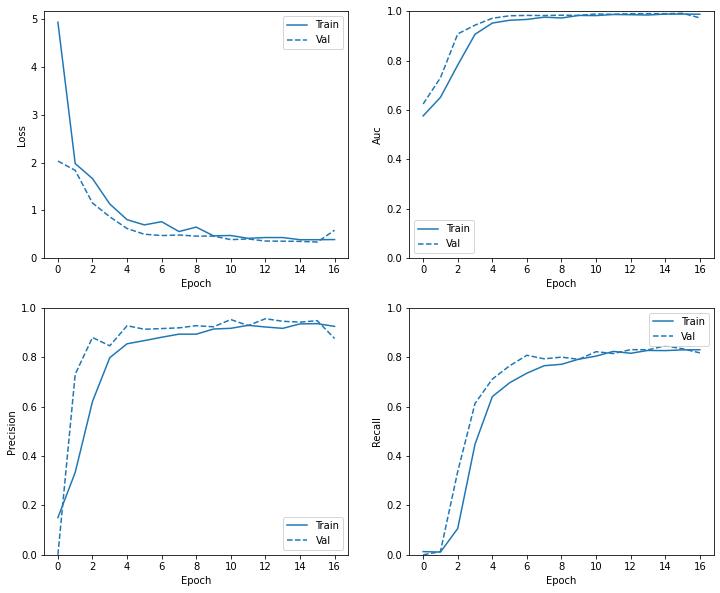

In [24]:
plot_metrics(history)

In [25]:
results

[0.5564521551132202,
 0.9646099805831909,
 0.8812589645385742,
 0.8285138010978699,
 0.9743967652320862]

**EVALUATE PERFORMANCE OF THE MODEL ON THE CLEAN SPECTROGRAMS**

In [26]:
model, history, results = get_model('mel_spectrogram')

Connection to Google drive successful
train folder ==> Angry class ==> has 225 files
train folder ==> Sad class ==> has 225 files
train folder ==> Calm class ==> has 225 files
train folder ==> Happy class ==> has 225 files
train folder ==> Disgust class ==> has 115 files
train folder ==> Fearful class ==> has 225 files
train folder ==> Surprised class ==> has 115 files
train folder ==> Neutral class ==> has 112 files
test folder ==> Angry class ==> has 76 files
test folder ==> Sad class ==> has 76 files
test folder ==> Calm class ==> has 76 files
test folder ==> Happy class ==> has 76 files
test folder ==> Disgust class ==> has 39 files
test folder ==> Fearful class ==> has 76 files
test folder ==> Surprised class ==> has 39 files
test folder ==> Neutral class ==> has 39 files
validation folder ==> Angry class ==> has 75 files
validation folder ==> Sad class ==> has 75 files
validation folder ==> Calm class ==> has 75 files
validation folder ==> Happy class ==> has 75 files
validation 

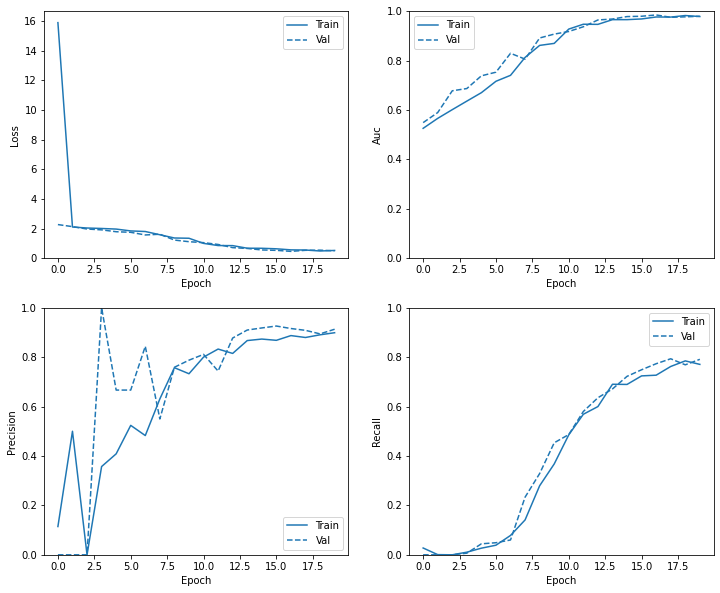

In [27]:
plot_metrics(history)

**RESULTS OF EVALUATION**

In [28]:
results

[0.48562613129615784,
 0.9600100517272949,
 0.8967136144638062,
 0.7686116695404053,
 0.9830619096755981]

**EVALUATE PERFORMANCE OF THE MODEL ON SPECTROGRAMS WITH WHITE NOISE**

In [29]:
model, history, results = get_model('mel_spectrogram_white_noisy')

Connection to Google drive successful
train folder ==> Angry class ==> has 225 files
train folder ==> Sad class ==> has 225 files
train folder ==> Calm class ==> has 225 files
train folder ==> Happy class ==> has 225 files
train folder ==> Disgust class ==> has 115 files
train folder ==> Fearful class ==> has 225 files
train folder ==> Surprised class ==> has 115 files
train folder ==> Neutral class ==> has 112 files
test folder ==> Angry class ==> has 76 files
test folder ==> Sad class ==> has 76 files
test folder ==> Calm class ==> has 76 files
test folder ==> Happy class ==> has 76 files
test folder ==> Disgust class ==> has 39 files
test folder ==> Fearful class ==> has 76 files
test folder ==> Surprised class ==> has 39 files
test folder ==> Neutral class ==> has 39 files
validation folder ==> Angry class ==> has 75 files
validation folder ==> Sad class ==> has 75 files
validation folder ==> Calm class ==> has 75 files
validation folder ==> Happy class ==> has 75 files
validation 

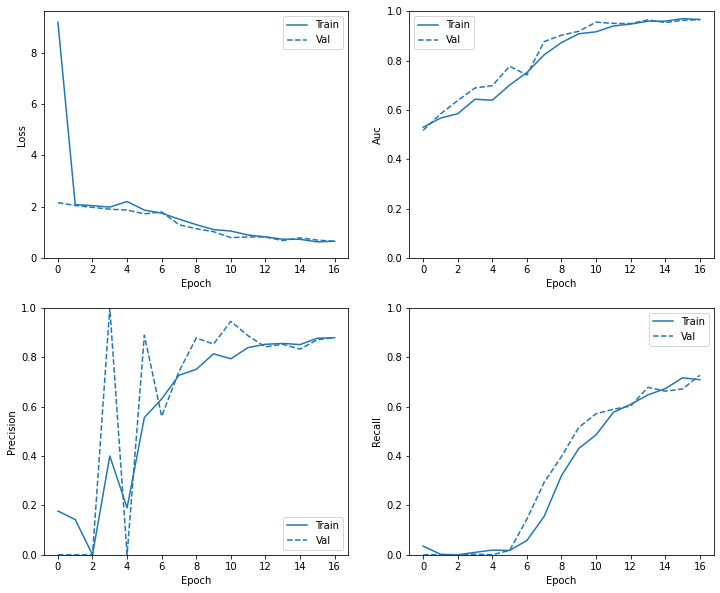

In [30]:
plot_metrics(history)

**RESULTS OF EVALUATION**

In [31]:
results

[0.6546149253845215,
 0.9544768333435059,
 0.8834951519966125,
 0.7323943376541138,
 0.9669346213340759]

**EVALUATE PERFORMANCE OF THE MODEL ON SPECTROGRAMS WITH URBAN NOISE**

In [32]:
model, history, results = get_model('mel_spectrogram_urban_noisy')

Connection to Google drive successful
train folder ==> Angry class ==> has 225 files
train folder ==> Sad class ==> has 225 files
train folder ==> Calm class ==> has 225 files
train folder ==> Happy class ==> has 225 files
train folder ==> Disgust class ==> has 115 files
train folder ==> Fearful class ==> has 225 files
train folder ==> Surprised class ==> has 115 files
train folder ==> Neutral class ==> has 112 files
test folder ==> Angry class ==> has 76 files
test folder ==> Sad class ==> has 76 files
test folder ==> Calm class ==> has 75 files
test folder ==> Happy class ==> has 76 files
test folder ==> Disgust class ==> has 39 files
test folder ==> Fearful class ==> has 75 files
test folder ==> Surprised class ==> has 39 files
test folder ==> Neutral class ==> has 39 files
validation folder ==> Angry class ==> has 75 files
validation folder ==> Sad class ==> has 75 files
validation folder ==> Calm class ==> has 75 files
validation folder ==> Happy class ==> has 75 files
validation 

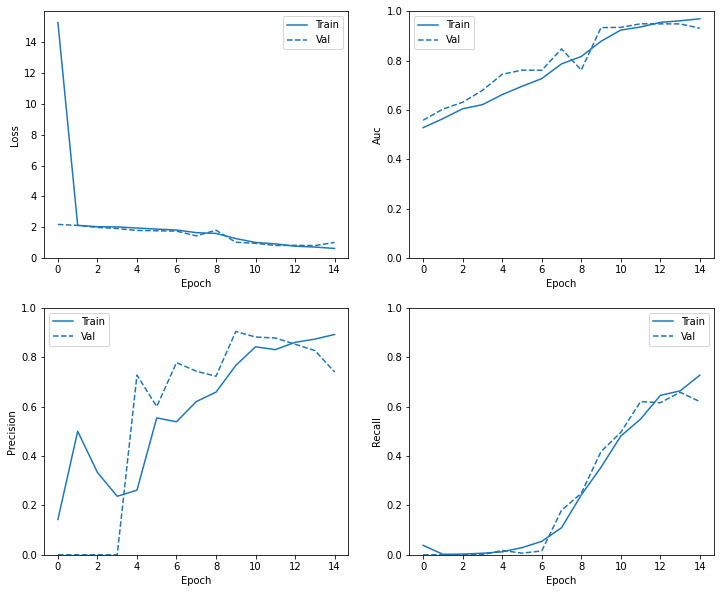

In [33]:
plot_metrics(history)

**RESULTS OF EVALUATION**

In [34]:
results

[0.9535741806030273,
 0.933080792427063,
 0.7777777910232544,
 0.6505050659179688,
 0.936671793460846]

**EVALUATE PERFORMANCE OF THE MODEL ON SPECTROGRAMS WITH WHITE AND URBAN NOISE**

In [35]:
model, history, results = get_model('mel_spectrogram_white_urban_noisy')

Connection to Google drive successful
train folder ==> Angry class ==> has 225 files
train folder ==> Sad class ==> has 225 files
train folder ==> Calm class ==> has 225 files
train folder ==> Happy class ==> has 225 files
train folder ==> Disgust class ==> has 115 files
train folder ==> Fearful class ==> has 223 files
train folder ==> Surprised class ==> has 115 files
train folder ==> Neutral class ==> has 112 files
test folder ==> Angry class ==> has 76 files
test folder ==> Sad class ==> has 76 files
test folder ==> Calm class ==> has 76 files
test folder ==> Happy class ==> has 75 files
test folder ==> Disgust class ==> has 39 files
test folder ==> Fearful class ==> has 76 files
test folder ==> Surprised class ==> has 39 files
test folder ==> Neutral class ==> has 38 files
validation folder ==> Angry class ==> has 75 files
validation folder ==> Sad class ==> has 75 files
validation folder ==> Calm class ==> has 75 files
validation folder ==> Happy class ==> has 75 files
validation 

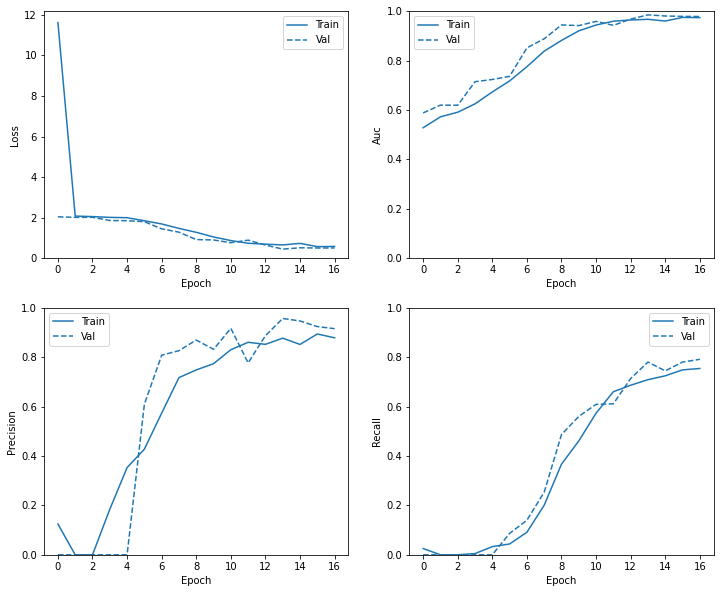

In [36]:
plot_metrics(history)

**RESULTS OF EVALUATION**

In [37]:
results

[0.49819275736808777,
 0.9646464586257935,
 0.9137529134750366,
 0.7919191718101501,
 0.9804413318634033]

**SAVE THE RESULTS OF THE MODEL**

In [38]:
model.save(base_path+'/ProjectModel')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: GDrive/My Drive/MSc Project/RAVDESS/ProjectModel/assets


In [60]:
def predict(x, m, model):
  import random
  audio_path=x+'/audio/'
  file=random.choice(os.listdir(audio_path))
  y,sr=librosa.load(audio_path+'/{}'.format(file))
  y,_=librosa.effects.trim(y, top_db=45)
  if m == 'speech' or 'Speech' or 'SPEECH':
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000, n_fft = 512)
  else:
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000, n_fft = 2048)
  S_dB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel-frequency spectrogram')
  plt.tight_layout()
  plt.savefig(x+'/prediction_folder/test/OUTPUT.png')

  import cv2
  x='GDrive/My Drive/MSc Project/Predictions'
  test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    x+'/prediction_folder/',
    image_size=(256, 256))

  prediction = model.predict(test_ds)
  prediction_classes = ['Angry', 'Sad', 'Calm', 'Happy', 'Disgust', 'Fearful', 'Surprised', 'Neutral']
  predict = {}
  for i in range(len(prediction[0])):
    predict[prediction_classes[i]]=prediction[0][i]
  import operator
  output = max(predict.items(), key=operator.itemgetter(1))[0]
  return output

Found 1 files belonging to 1 classes.


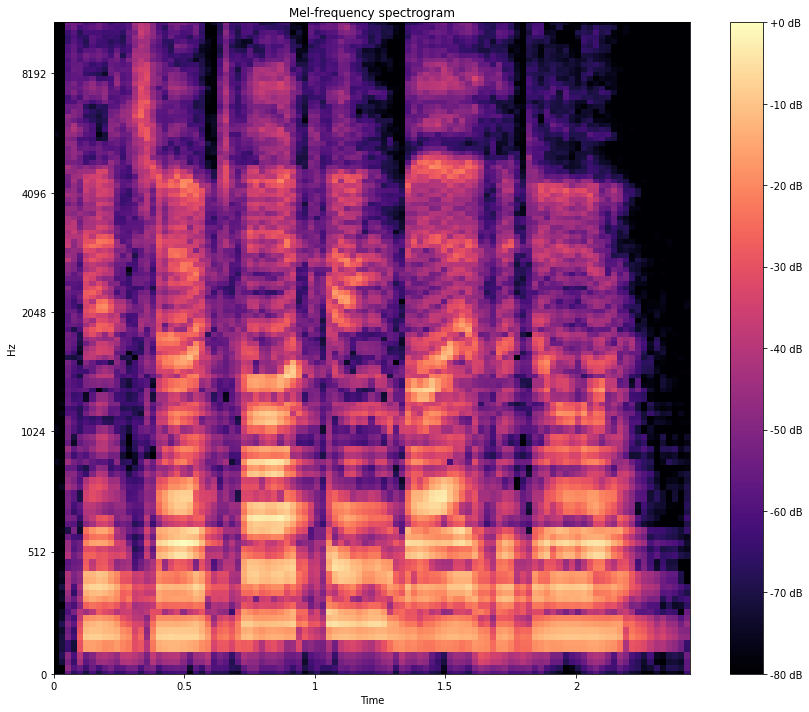

In [61]:
prediction = predict('GDrive/My Drive/MSc Project/Predictions', 'speech', model=model)

In [62]:
prediction

'Disgust'

## **MUSIC RECOMMENDATION**

The music recommender system is built using the Emotify Dataset.

In [65]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [66]:
google_connection()

Connection to Google drive successful


In [67]:
ratings_file = 'GDrive/My Drive/MSc Project/Emotify.csv' #Path to emotify csv file
emotify_path='GDrive/My Drive/MSc Project/Emotify' #Emotify root path
df = pd.read_csv(ratings_file)

In [68]:
df.head()

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
0,1,classical,0,1,0,0,0,0,1,1,0,3,1,0,21,1,English
1,1,classical,0,0,0,1,0,0,0,0,0,3,0,1,41,1,Dutch
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,0,24,1,English
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,0,32,0,Spanish
4,1,classical,0,0,0,1,1,0,0,0,0,4,0,1,21,0,English


In [69]:
df = df.drop(columns = [' mother tongue', ' liked'])

In [70]:
df.head()

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,disliked,age,gender
0,1,classical,0,1,0,0,0,0,1,1,0,3,0,21,1
1,1,classical,0,0,0,1,0,0,0,0,0,3,1,41,1
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,24,1
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,32,0
4,1,classical,0,0,0,1,1,0,0,0,0,4,1,21,0


We identify no corellation between the columns in the dataset.

In [71]:
df.corr()

,track id,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,disliked,age,gender
track id,1.000000,-0.035889,-0.080450,-0.000833,0.020576,-0.010294,-0.000670,-0.025160,0.060297,0.025009,-0.061634,0.130116,-0.140463,0.056507
amazement,-0.035889,1.000000,-0.034695,0.002308,-0.099185,-0.072947,0.046472,0.155424,-0.114553,-0.146969,0.048178,-0.131652,-0.042554,0.032726
solemnity,-0.080450,-0.034695,1.000000,-0.072575,-0.059082,-0.012520,0.012750,-0.098162,-0.040608,-0.034689,0.021121,-0.114655,-0.008019,-0.020170
tenderness,-0.000833,0.002308,-0.072575,1.000000,0.087216,0.140270,-0.156100,-0.091257,-0.195904,-0.023642,0.012068,-0.119279,-0.004660,0.000914
nostalgia,0.020576,-0.099185,-0.059082,0.087216,1.000000,0.057075,-0.155181,-0.173886,-0.190797,0.118118,-0.019525,-0.081364,-0.020523,0.016185
calmness,-0.010294,-0.072947,-0.012520,0.140270,0.057075,1.000000,-0.212538,-0.193518,-0.281527,-0.069646,-0.003863,-0.126638,-0.057663,-0.013618
power,-0.000670,0.046472,0.012750,-0.156100,-0.155181,-0.212538,1.000000,0.128937,0.038252,-0.121927,0.036659,-0.063650,0.005511,0.006564
joyful_activation,-0.025160,0.155424,-0.098162,-0.091257,-0.173886,-0.193518,0.128937,1.000000,-0.115181,-0.228275,0.016420,-0.138436,0.019701,-0.003549
tension,0.060297,-0.114553,-0.040608,-0.195904,-0.190797,-0.281527,0.038252,-0.115181,1.000000,0.010221,-0.018809,0.269107,-0.003834,0.005059
sadness,0.025009,-0.146969,-0.034689,-0.023642,0.118118,-0.069646,-0.121927,-0.228275,0.010221,1.000000,-0.052243,0.085616,-0.029675,0.022005


In [72]:
df['Score'] = df[' amazement'] + df[' nostalgia'] + df[' calmness'] + df[' joyful_activation'] + df[' tenderness'] + df[' solemnity'] - df[' tension'] - df[' sadness']
df

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,disliked,age,gender,Score
0,1,classical,0,1,0,0,0,0,1,1,0,3,0,21,1,1
1,1,classical,0,0,0,1,0,0,0,0,0,3,1,41,1,1
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,24,1,0
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,32,0,1
4,1,classical,0,0,0,1,1,0,0,0,0,4,1,21,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,400,pop,1,1,0,0,0,0,1,0,0,3,0,26,1,3
8403,400,pop,0,0,0,1,0,0,1,0,1,3,1,29,0,1
8404,400,pop,0,0,0,0,0,0,0,1,0,4,1,34,1,-1
8405,400,pop,1,0,0,0,0,0,1,1,0,5,0,39,1,1


In [73]:
df['track id']=df['track id']%100
df['track id']=df['track id'].replace(0, 100)
df

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,disliked,age,gender,Score
0,1,classical,0,1,0,0,0,0,1,1,0,3,0,21,1,1
1,1,classical,0,0,0,1,0,0,0,0,0,3,1,41,1,1
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,24,1,0
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,32,0,1
4,1,classical,0,0,0,1,1,0,0,0,0,4,1,21,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,100,pop,1,1,0,0,0,0,1,0,0,3,0,26,1,3
8403,100,pop,0,0,0,1,0,0,1,0,1,3,1,29,0,1
8404,100,pop,0,0,0,0,0,0,0,1,0,4,1,34,1,-1
8405,100,pop,1,0,0,0,0,0,1,1,0,5,0,39,1,1


In [74]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(df.iloc[:,2:len(df.columns)])
exp_variance = pca.explained_variance_ratio_

print("Explained variance ratio : \n{}".format(pca.explained_variance_ratio_))
print("\n")
print("Number of components = {}".format(pca.n_components_))

Explained variance ratio : 
[9.71838975e-01 1.17460404e-02 6.08092188e-03 1.84520312e-03
 1.53564865e-03 1.20998330e-03 1.10742473e-03 9.85093486e-04
 8.79764931e-04 8.33279196e-04 7.57533899e-04 6.78727681e-04
 5.01403436e-04 2.87799040e-33]


Number of components = 14


The total variance in the data is described by 14 principal components

Text(0.5, 0, 'Principal Component #')

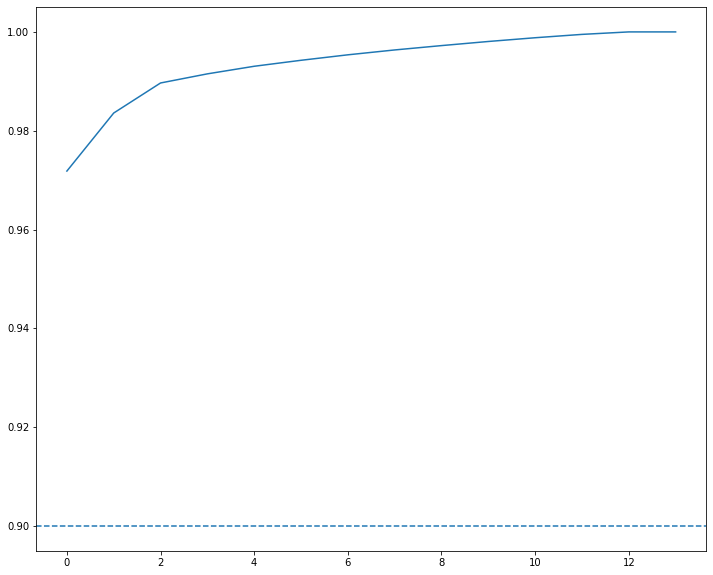

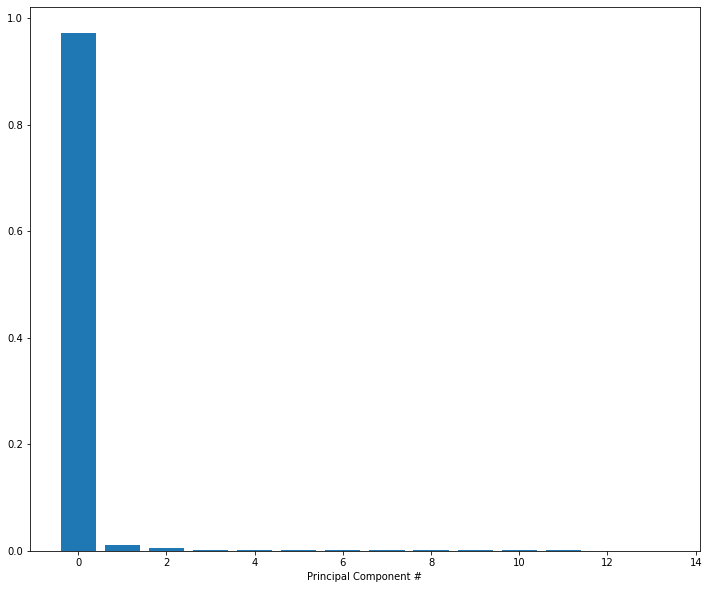

In [75]:
import numpy as np
cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(range(14), cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')

fig, ax = plt.subplots()
ax.bar(range(14), exp_variance)
ax.set_xlabel('Principal Component #')

In [76]:
df = df.sample(frac=1).reset_index(drop=True)

In [77]:
df.head()

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,disliked,age,gender,Score
0,37,classical,0,0,0,0,0,0,0,0,1,3,0,62,1,-1
1,14,pop,0,0,0,0,1,0,0,0,1,5,0,28,0,0
2,45,electronic,0,1,0,0,0,1,0,1,0,4,0,23,0,0
3,44,electronic,0,1,0,0,0,1,0,0,0,4,0,65,0,1
4,55,pop,1,0,1,0,0,0,1,0,0,4,0,32,0,3


In [79]:
df1=df[df['Score']>3]
df2=df[df['Score']==3]
df3=df[df['Score']<3]

**df3 represents positive emotion inducing audio.**

---


**df2 represents neutral emotion inducing audio.**

---

**df1 represents negative emotion inducing audio.**

In [80]:
df1.head()

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,disliked,age,gender,Score
4466,43,classical,1,0,1,1,0,1,1,0,0,5,1,66,0,4
5331,52,classical,1,1,1,0,0,0,1,0,0,3,0,25,0,4
5665,99,pop,0,1,1,1,1,0,0,0,0,5,0,39,0,4
6214,83,classical,1,1,1,1,0,0,0,0,0,3,1,21,1,4


In [81]:
df2.head()

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,disliked,age,gender,Score
4,55,pop,1,0,1,0,0,0,1,0,0,4,0,32,0,3
6,4,rock,1,0,1,1,0,0,0,0,0,4,0,47,1,3
29,77,classical,0,0,0,1,1,0,1,0,0,2,0,23,1,3
43,84,rock,0,0,1,1,1,0,0,0,0,4,0,17,0,3
48,70,rock,0,0,0,1,1,0,1,0,0,3,0,25,0,3


In [82]:
df3.head()

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,disliked,age,gender,Score
0,37,classical,0,0,0,0,0,0,0,0,1,3,0,62,1,-1
1,14,pop,0,0,0,0,1,0,0,0,1,5,0,28,0,0
2,45,electronic,0,1,0,0,0,1,0,1,0,4,0,23,0,0
3,44,electronic,0,1,0,0,0,1,0,0,0,4,0,65,0,1
5,7,rock,0,0,0,1,0,1,1,0,0,3,0,25,0,2


**PLAYING THE SOUND REQUIRED TO CHANGE EMOTION**

In [84]:
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile
negative_emotions = ['Sad', 'Angry', 'Fearful', 'disgust']
positive_emotions = ['Happy, Surprised']
if negative_emotions.count(prediction)>0:
  y = df.loc[df.index[random.randint(0,len(df1))]]
  print('NEGATIVE EMOTION DETECTED: NOW PLAYING track id:{}, genre: {}'.format(y.iloc[0], y.iloc[1]))
elif positive_emotions.count(prediction)>0:
  pass
else:
  y = df.loc[df.index[random.randint(0,len(df2))]]
  print('NEUTRAL EMOTION DETECTED: NOW PLAYING track id:{}, genre: {}'.format(y.iloc[0], y.iloc[1]))
Audio(emotify_path+'/{}/{}.mp3'.format(y.iloc[1], y.iloc[0]), autoplay=True)

NEUTRAL EMOTION DETECTED: NOW PLAYING track id:31, genre: pop
